In [1]:
import numpy as np
import pandas as pd
import os
import sklearn
import tensorflow as tf
from tensorflow import keras

In [2]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

4423680/4422102 [==============================] - 0s 0us/step


In [4]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [6]:
from functools import partial

In [7]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [8]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[28, 28, 1]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [9]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5
1719/1719 [==============================] - 101s 37ms/step - loss: 0.5124 - accuracy: 0.8247 - val_loss: 0.3565 - val_accuracy: 0.8722
Epoch 2/5
1719/1719 [==============================] - 62s 36ms/step - loss: 0.3420 - accuracy: 0.8794 - val_loss: 0.4019 - val_accuracy: 0.8530
Epoch 3/5
1719/1719 [==============================] - 61s 36ms/step - loss: 0.3190 - accuracy: 0.8869 - val_loss: 0.3028 - val_accuracy: 0.8862
Epoch 4/5
1719/1719 [==============================] - 61s 36ms/step - loss: 0.2852 - accuracy: 0.8983 - val_loss: 0.2807 - val_accuracy: 0.8930
Epoch 5/5
1719/1719 [==============================] - 62s 36ms/step - loss: 0.2524 - accuracy: 0.9088 - val_loss: 0.3004 - val_accuracy: 0.8796


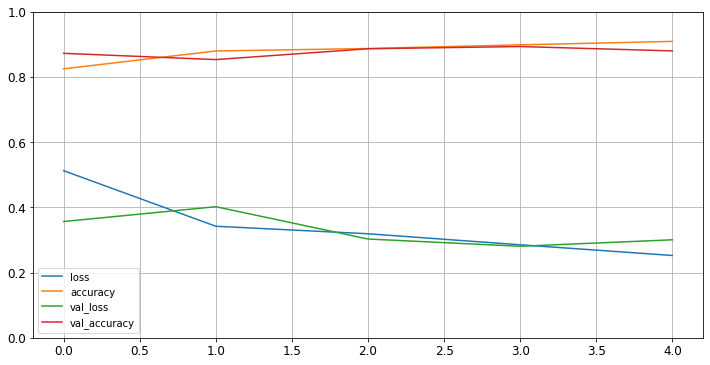

In [10]:
pd.DataFrame(history.history).plot(figsize = (12,6))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()